In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            #loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0514_Focal_Loss_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.4
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 8s 859ms/step - loss: 0.0553
Average validation loss: 0.13532671332359314
4/4 [==============================] - 8s 879ms/step - loss: 0.0553 - val_loss: 0.1353
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 12s 950ms/step - loss: 0.0396 - val_loss: 0.1353
Average validation loss: 0.13090215623378754
4/4 [==============================] - 12s 967ms/step - loss: 0.0396 - val_loss: 0.1331
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 16s 928ms/step - loss: 0.0302 - val_loss: 0.1331
Average validation loss: 0.14772027730941772
4/4 [==============================] - 16s 939ms/step - loss: 0.0302 - val_loss: 0.1380
Epoch 4/10
4/4 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 7s 843ms/step - loss: 0.0020
Average validation loss: 0.15023817121982574
8/8 [==============================] - 7s 855ms/step - loss: 0.0020 - val_loss: 0.1502
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 14s 827ms/step - loss: 0.0019 - val_loss: 0.1502
Average validation loss: 0.27133771777153015
8/8 [==============================] - 14s 844ms/step - loss: 0.0019 - val_loss: 0.2108
Epoch 3/10
8/8 [==============================] - 20s 782ms/step - loss: 0.0019 - val_loss: 0.2108
Average validation loss: 0.2061261087656021
8/8 [==============================] - 20s 800ms/step - loss: 0.0019 - val_loss: 0.2092
Epoch 4/10
8/8 [==============================] - 26s 784ms/step - loss: 0.0018 - val_loss: 0.2092
Average validation loss: 0.1932772994041443
8/8 [==============================] - 26s 798m

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 721ms/step - loss: 0.0022
Average validation loss: 0.20017101367314658
12/12 [==============================] - 9s 732ms/step - loss: 0.0022 - val_loss: 0.2002
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 715ms/step - loss: 0.0022 - val_loss: 0.2002
Average validation loss: 0.08752067138751347
12/12 [==============================] - 18s 728ms/step - loss: 0.0022 - val_loss: 0.1438
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 717ms/step - loss: 0.0022 - val_loss: 0.1438
Average validation loss: 0.09572583436965942
12/12 [==============================] - 27s 729ms/step - loss: 0.0022 - val_loss: 0.1278
Epoch 4/10
12/12 [============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 721ms/step - loss: 0.0018
Average validation loss: 0.22084761783480644
16/16 [==============================] - 12s 736ms/step - loss: 0.0018 - val_loss: 0.2208
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 718ms/step - loss: 0.0017 - val_loss: 0.2208
Average validation loss: 0.21025951951742172
16/16 [==============================] - 24s 734ms/step - loss: 0.0017 - val_loss: 0.2156
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 716ms/step - loss: 0.0016 - val_loss: 0.2156
Average validation loss: 0.23965561389923096
16/16 [==============================] - 35s 729ms/step - loss: 0.0016 - val_loss: 0.2236
Epoch 4/10
16/16 [==========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 737ms/step - loss: 0.0017
Average validation loss: 0.22163941860198974
20/20 [==============================] - 15s 750ms/step - loss: 0.0017 - val_loss: 0.2216
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 716ms/step - loss: 0.0014 - val_loss: 0.2216
Average validation loss: 0.2085916668176651
20/20 [==============================] - 30s 727ms/step - loss: 0.0014 - val_loss: 0.2151
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 722ms/step - loss: 0.0013 - val_loss: 0.2151
Average validation loss: 0.18367030918598176
20/20 [==============================] - 44s 734ms/step - loss: 0.0013 - val_loss: 0.2046
Saved model weights to 'c:\Us

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 716ms/step - loss: 0.0014
Average validation loss: 0.15676667044560114
24/24 [==============================] - 17s 727ms/step - loss: 0.0014 - val_loss: 0.1568
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 714ms/step - loss: 0.0012 - val_loss: 0.1568
Average validation loss: 0.16165582090616226
24/24 [==============================] - 35s 725ms/step - loss: 0.0012 - val_loss: 0.1592
Epoch 3/10
24/24 [==============================] - 53s 742ms/step - loss: 0.0011 - val_loss: 0.1592
Average validation loss: 0.17623073607683182
24/24 [==============================] - 53s 754ms/step - loss: 0.0011 - val_loss: 0.1649
Epoch 4/10
24/24 [==============================] - 71s 735ms/step - loss: 0.0011 - val_loss: 0.1649
Average validation loss: 0.19092493255933127
24/24 [======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 727ms/step - loss: 0.0016
Average validation loss: 0.18007613122463226
40/40 [==============================] - 30s 737ms/step - loss: 0.0016 - val_loss: 0.1801
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 720ms/step - loss: 0.0015 - val_loss: 0.1801
Average validation loss: 0.1720981627702713
40/40 [==============================] - 59s 731ms/step - loss: 0.0015 - val_loss: 0.1761
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 88s 716ms/step - loss: 0.0014 - val_loss: 0.1761
Average validation loss: 0.14898400008678436
40/40 [==============================] - 88s 727ms/step - loss: 0.0014 - val_loss: 0.1671
Saved model weights to 'c:\Us

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 723ms/step - loss: 0.0012
Average validation loss: 0.20717792958021164
48/48 [==============================] - 35s 734ms/step - loss: 0.0012 - val_loss: 0.2072
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 727ms/step - loss: 0.0011 - val_loss: 0.2072
Average validation loss: 0.1725978528459867
48/48 [==============================] - 71s 739ms/step - loss: 0.0011 - val_loss: 0.1899
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 106s 740ms/step - loss: 9.8846e-04 - val_loss: 0.1899
Average validation loss: 0.19053786993026733
48/48 [==============================] - 107s 753ms/step - loss: 9.8846e-04 - val_loss: 0.1901
Epoch 4/10
48/48 [=

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 728ms/step - loss: 0.0012
Average validation loss: 0.19361359626054764
56/56 [==============================] - 41s 741ms/step - loss: 0.0012 - val_loss: 0.1936
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 722ms/step - loss: 9.7013e-04 - val_loss: 0.1936
Average validation loss: 0.19655308766024454
56/56 [==============================] - 83s 734ms/step - loss: 9.7013e-04 - val_loss: 0.1951
Epoch 3/10
56/56 [==============================] - 124s 729ms/step - loss: 8.6545e-04 - val_loss: 0.1951
Average validation loss: 0.1716776607292039
56/56 [==============================] - 124s 741ms/step - loss: 8.6545e-04 - val_loss: 0.1873
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_70.pth'.
Epoch 4/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 723ms/step - loss: 9.9204e-04
Average validation loss: 0.18187687918543816
64/64 [==============================] - 47s 734ms/step - loss: 9.9204e-04 - val_loss: 0.1819
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 722ms/step - loss: 8.4520e-04 - val_loss: 0.1819
Average validation loss: 0.15905872080475092
64/64 [==============================] - 94s 733ms/step - loss: 8.4520e-04 - val_loss: 0.1705
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 141s 725ms/step - loss: 7.6210e-04 - val_loss: 0.1705
Average validation loss: 0.16712675336748362
64/64 [==============================] - 141s 736ms/step - loss: 7.6210e-04 - val_loss: 0.1694
Ep

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 720ms/step - loss: 8.0845e-04
Average validation loss: 0.17798435439666113
72/72 [==============================] - 53s 732ms/step - loss: 8.0845e-04 - val_loss: 0.1780
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 105s 721ms/step - loss: 6.9810e-04 - val_loss: 0.1780
Average validation loss: 0.16947382936875025
72/72 [==============================] - 106s 732ms/step - loss: 6.9810e-04 - val_loss: 0.1737
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 158s 726ms/step - loss: 6.5581e-04 - val_loss: 0.1737
Average validation loss: 0.17114125026596916
72/72 [==============================] - 159s 738ms/step - loss: 6.5581e-04 - val_loss: 0.1729


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 722ms/step - loss: 7.3009e-04
Average validation loss: 0.1800607532262802
80/80 [==============================] - 59s 734ms/step - loss: 7.3009e-04 - val_loss: 0.1801
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 117s 721ms/step - loss: 6.2083e-04 - val_loss: 0.1801
Average validation loss: 0.15758221447467805
80/80 [==============================] - 117s 733ms/step - loss: 6.2083e-04 - val_loss: 0.1688
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 176s 726ms/step - loss: 5.6796e-04 - val_loss: 0.1688
Average validation loss: 0.1727498784661293
80/80 [==============================] - 177s 737ms/step - loss: 5.6796e-04 - val_loss: 0.1701


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 719ms/step - loss: 0.0011
Average validation loss: 0.16361145488917828
96/96 [==============================] - 70s 731ms/step - loss: 0.0011 - val_loss: 0.1636
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 720ms/step - loss: 8.7934e-04 - val_loss: 0.1636
Average validation loss: 0.17309489535788694
96/96 [==============================] - 141s 732ms/step - loss: 8.7934e-04 - val_loss: 0.1684
Epoch 3/10
96/96 [==============================] - 209s 718ms/step - loss: 7.7403e-04 - val_loss: 0.1684
Average validation loss: 0.17265379428863525
96/96 [==============================] - 211s 730ms/step - loss: 7.7403e-04 - val_loss: 0.1698
Epoch 4/10
96/96 [==============================] - 279s 716ms/step - loss: 6.9142e-04 - val_loss: 0.1698
Average validation loss: 0.1507416839400927
96/9

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 87s 725ms/step - loss: 7.7750e-04
Average validation loss: 0.1630575880408287
120/120 [==============================] - 88s 737ms/step - loss: 7.7750e-04 - val_loss: 0.1631
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 175s 721ms/step - loss: 6.6310e-04 - val_loss: 0.1631
Average validation loss: 0.16406266589959462
120/120 [==============================] - 176s 733ms/step - loss: 6.6310e-04 - val_loss: 0.1636
Epoch 3/10
120/120 [==============================] - 264s 727ms/step - loss: 5.8484e-04 - val_loss: 0.1636
Average validation loss: 0.16159109125534693
120/120 [==============================] - 265s 739ms/step - loss: 5.8484e-04 - val_loss: 0.1629
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_si

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 718ms/step - loss: 6.7463e-04
Average validation loss: 0.1688000683983167
144/144 [==============================] - 105s 730ms/step - loss: 6.7463e-04 - val_loss: 0.1688
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 209s 719ms/step - loss: 5.6865e-04 - val_loss: 0.1688
Average validation loss: 0.16714220080110762
144/144 [==============================] - 210s 731ms/step - loss: 5.6865e-04 - val_loss: 0.1680
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 314s 721ms/step - loss: 5.3386e-04 - val_loss: 0.1680
Average validation loss: 0.15451644361019135
144/144 [==============================] - 316s 733ms/step - loss: 5.3386e-04 - va

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 717ms/step - loss: 5.0214e-04
Average validation loss: 0.1606821309775114
160/160 [==============================] - 116s 728ms/step - loss: 5.0214e-04 - val_loss: 0.1607
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 232s 722ms/step - loss: 4.5335e-04 - val_loss: 0.1607
Average validation loss: 0.1638438168913126
160/160 [==============================] - 234s 734ms/step - loss: 4.5335e-04 - val_loss: 0.1623
Epoch 3/10
160/160 [==============================] - 349s 720ms/step - loss: 4.2324e-04 - val_loss: 0.1623
Average validation loss: 0.1648003775626421
160/160 [==============================] - 351s 731ms/step - loss: 4.2324e-04 - val_loss: 0.1631
Epoch 4/10
160/160 [==============================] - 466s 717ms/step - loss: 4.0627e-04 - val_loss: 0.1631
Average validation loss: 0.

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 720ms/step - loss: 9.0899e-04
Average validation loss: 0.16555641680955888
200/200 [==============================] - 146s 732ms/step - loss: 9.0899e-04 - val_loss: 0.1656
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 290s 716ms/step - loss: 7.5760e-04 - val_loss: 0.1656
Average validation loss: 0.16286888152360915
200/200 [==============================] - 292s 728ms/step - loss: 7.5760e-04 - val_loss: 0.1642
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 435s 717ms/step - loss: 6.7725e-04 - val_loss: 0.1642
Average validation loss: 0.16412957429885863
200/200 [==============================] - 438s 729ms/step - loss: 6.7725e-04 - v

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:49 - loss: 1.4458e-04

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 722ms/step - loss: 6.2324e-04
Average validation loss: 0.1582987442612648
240/240 [==============================] - 176s 733ms/step - loss: 6.2324e-04 - val_loss: 0.1583
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_40\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 349s 721ms/step - loss: 5.2158e-04 - val_loss: 0.1583
Average validation loss: 0.160854405661424
240/240 [==============================] - 352s 732ms/step - loss: 5.2158e-04 - val_loss: 0.1596
Epoch 3/10
240/240 [==============================] - 524s 717ms/step - loss: 4.7416e-04 - val_loss: 0.1596
Average validation loss: 0.15902971128622692
240/240 [==============================] - 527s 729ms/step - loss: 4.7416e-04 - val_loss: 0.1594
Epoch 4/10
240/240 [==============================] - 699s 719ms/step - loss: 4.4462e-04 - val_loss: 0.1594
Average validation loss: 0.

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.23367172732949257, 0.19563415385782718, 0.19684119666616115, 0.20404571339488028, 0.203064205467701, 0.18491863081852597, 0.1866493625640869, 0.17999301629761852, 0.1777170350828341, 0.17359892150387168, 0.16855552282598282, 0.17117072384059429, 0.1651245001206795, 0.1600991278986136, 0.16187126432855925, 0.1625737562030554, 0.16512293111085893, 0.16213276756803197]
std_val_losses =  [0.17804297580551767, 0.059838628517441504, 0.08570195201736967, 0.0526999526130862, 0.04549531807214992, 0.016658422721037732, 0.025591929102926934, 0.010730703055319386, 0.019952919404103136, 0.007785543482307289, 0.008112658217360435, 0.008774118659441353, 0.00980301533352218, 0.00906147654015077, 0.006308434453327603, 0.0045834761385316605, 0.0065364678659668015, 0.004932677484294303]


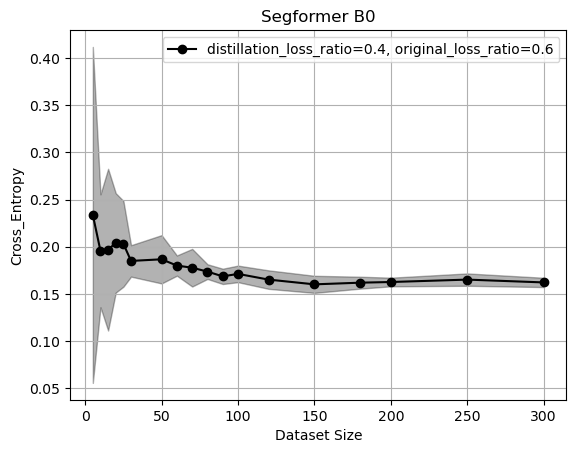

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()